In [64]:
import argparse
from copy import deepcopy
import logging
import random
from collections import defaultdict
from os.path import join
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, mean_squared_error, r2_score, f1_score, precision_recall_curve
from sklearn.model_selection import train_test_split
import joblib
import imodels
import inspect
import os.path
import imodelsx.cache_save_utils
import sys
import torch

#path_to_repo = os.path.dirname(os.path.dirname(os.path.abspath(__file__)))

#os.chdir(path_to_repo)
#os.chdir('/home/mattyshen/interpretableDistillation')
sys.path.append('..')

import idistill.model
import idistill.data

def distill_model(student, X_train_teacher, y_train_teacher, r, feature_names = None):
    """Distill the teacher model using the student model"""
    
    fit_parameters = inspect.signature(student.fit).parameters.keys()
    if "feature_names" in fit_parameters and feature_names is not None:
        student.fit(X_train_teacher, y_train_teacher, feature_names=feature_names)
    else:
        student.fit(X_train_teacher, y_train_teacher)

    return r, student

def evaluate_student(student, X_train, X_test, y_train, y_test, metric, task, r):
    """Evaluate student performance on each split"""
    
    metrics = {
            "accuracy": accuracy_score,
            "mse": mean_squared_error,
            "r2": r2_score,
            "f1": f1_score,
        
        }
    
    metric_fn = metrics[metric]
    
    for split_name, (X_, y_) in zip(
        ["train", "test"], [(X_train, y_train), (X_test, y_test)]
    ):
        y_pred_ = process_student_eval(student.predict(X_))
        r[f"student_{task}_{split_name}_{metric}"] = metric_fn(y_, y_pred_)

    return r

def evaluate_teacher(y_train_teacher, y_test_teacher, y_train, y_test, metric, task, r):
    metrics = {
            "accuracy": accuracy_score,
            "mse": mean_squared_error,
            "r2": r2_score,
            "f1": f1_score,
        
        }
    
    metric_fn = metrics[metric]
    
    for split_name, (y_teacher_, y_) in zip(
        ["train", "test"], [(y_train_teacher, y_train), (y_test_teacher, y_test)]
    ):
        r[f"teacher_{task}_{split_name}_{metric}"] = metric_fn(y_teacher_, y_)
    
    return r

def predict_teacher(teacher, X):
    ### TODO: handle teacher prediction outputs (X is intended to be concept design matrix, output is intended to be logits)###

    y_pred_torch = teacher.sec_model(torch.tensor(X.values, dtype=torch.float32).to('cuda:0'))
    y_pred = pd.DataFrame(y_pred_torch.detach().cpu().numpy())
        
    return y_pred

def load_teacher_model(teacher_path):
    ### TODO: load in teacher model using model_path ###
    
    sys.path.append('/home/mattyshen/ConceptBottleneck')
    teacher = torch.load(teacher_path, weights_only=False)
    teacher.to('cuda:0')
    teacher.eval()
    sys.path.append('/home/mattyshen/DistillationEdit')
    
    return teacher

def generate_tabular_distillation_data(teacher, train_path, test_path):
    ### TODO: generate teacher train and test data using model, train_path, and test_path ###
    
    sys.path.append('/home/mattyshen/ConceptBottleneck/CUB')
    from dataset import load_data
    from config import BASE_DIR
    
    def get_cub_data(teacher, path, data = 'train', override_train = True, batch_size = 32):
        with torch.no_grad():
            if data == 'test':
                test_dir = path
                #print(test_dir)
                # loader = load_data([test_dir], True, False, batch_size, image_dir='images',
                #                    n_class_attr=2, override_train=override_train)
                loader = load_data([test_dir], True, False, batch_size, image_dir='images',
                                   n_class_attr=2)
            else:
                train_dir = path
                val_dir = '/home/mattyshen/ConceptBottleneck/CUB_processed/class_attr_data_10/val.pkl'
                #print(train_dir, val_dir)
                # loader = load_data([train_dir, val_dir], True, False, batch_size, image_dir='images',
                #                    n_class_attr=2, override_train=override_train)
                loader = load_data([train_dir, val_dir], True, False, batch_size, image_dir='images',
                                    n_class_attr=2)
                
            torch.manual_seed(0)
            
            attrs_true = []
            attrs_hat = []
            labels_true = []
            labels_hat = []
            for data_idx, data in enumerate(loader):
                inputs, labels, attr_labels = data
                attr_labels = torch.stack(attr_labels).t()

                inputs_var = torch.autograd.Variable(inputs).to('cuda:0')
                labels_var = torch.autograd.Variable(labels).to('cuda:0')
                outputs = teacher(inputs_var)
                class_outputs = outputs[0]

                attr_outputs = outputs[1:] #[torch.nn.Sigmoid()(o) for o in outputs[1:]]
                attr_outputs_sigmoid = attr_outputs

                attrs_hat.append(torch.stack(attr_outputs).squeeze(2).detach().cpu().numpy())
                attrs_true.append(attr_labels.T)
                labels_hat.append(class_outputs.detach().cpu().numpy())
                labels_true.append(labels)

            X_hat = pd.DataFrame(np.concatenate(attrs_hat, axis=1).T, columns = [f'c{i}' for i in range(1, 113)])
            X = pd.DataFrame(np.concatenate(attrs_true, axis = 1).T, columns = [f'c{i}' for i in range(1, 113)])

            y = pd.Series(np.concatenate([l.numpy().reshape(-1, ) for l in labels_true]))
            y_hat = pd.DataFrame(np.concatenate(labels_hat, axis = 0))

            del attrs_hat
            del labels
            del labels_hat
            del loader
            del data
            del inputs
            del outputs
            del class_outputs
            del attr_outputs
            del attr_outputs_sigmoid
            del inputs_var
            del labels_var
            torch.cuda.empty_cache()

            return X_hat, X, y_hat, y

    X_train_teacher, X_train, y_train_teacher, y_train = get_cub_data(teacher, train_path)
    X_test_teacher, X_test, y_test_teacher, y_test = get_cub_data(teacher, test_path, data = 'test')
    
    sys.path.append('/home/mattyshen/DistillationEdit')
    
    return X_train_teacher, X_test_teacher, X_train, X_test, y_train_teacher, y_test_teacher, y_train, y_test

def process_distillation_data(X_train_teacher, X_test_teacher, X_train, X_test, y_train_teacher, y_test_teacher, y_train, y_test):
    ### TODO: process (i.e. binarize, F1-max binarize) data for distillation ###
    
    def find_optimal_threshold(y_true, y_probs):
        
#         threshs = np.arange(0, 1.01, 0.01)
#         prop_correct = [accuracy_score(y_true, y_probs > t) for t in threshs]
        
#         return threshs[np.argmax(prop_correct)]
        precisions, recalls, thresholds = precision_recall_curve(y_true, y_probs)
        f1_scores = 2 * (precisions * recalls) / (precisions + recalls)
        optimal_idx = np.argmax(f1_scores)
        optimal_threshold = thresholds[optimal_idx]
        return optimal_threshold
    def sigmoid(x):
        return 1/ (1+np.exp(-x))

#     optimal_thresholds = []
#     for class_idx in range(X_train_teacher.shape[1]):
#         y_true_class = X_train.iloc[:, class_idx]
#         y_probs_class = X_train_teacher.iloc[:, class_idx]
#         optimal_thresholds.append(find_optimal_threshold(y_true_class, y_probs_class))
        
#     optimal_thresholds = np.array(optimal_thresholds)

    # return X_train_teacher.applymap(sigmoid), X_test_teacher.applymap(sigmoid), y_train_teacher, y_test_teacher
    # optimal_thresholds = find_optimal_threshold(X_train.values.reshape(-1, ), X_train_teacher.values.reshape(-1, ))
    # print(np.unique(optimal_thresholds))
    # return (X_train_teacher > optimal_thresholds).astype(int), (X_test_teacher > optimal_thresholds).astype(int), y_train_teacher, y_test_teacher
    # best_t = np.argmin([np.mean(((X_train_teacher.values > t).astype(int) - X_train.values)**2) for t in np.arange(0, 1, 0.01)])
    # thresh = np.arange(0, 1, 0.01)[best_t]
    # print(thresh)
    #thresh = 0
    X_train_s = X_train_teacher.applymap(sigmoid)
    X_test_s = X_test_teacher.applymap(sigmoid)
    
    best_t = np.argmin([np.mean(((X_train_s.values > t).astype(int) - X_train.values)**2) for t in np.arange(0, 1, 0.01)])
    thresh = np.arange(0, 1, 0.01)[best_t]
    print(thresh)
    
    return (X_train_s > thresh).astype(int), (X_test_s > thresh).astype(int), y_train_teacher, y_test_teacher

def process_student_eval(y_student):
    ### TODO: handle student prediction outputs to match metrics ###
    
    y_pred = np.argmax(y_student, axis = 1)

    return y_pred

def process_teacher_eval(y_teacher):
    ### TODO: process teacher model predictions for evaluations (sometimes we distill a teacher model using a regressor, but want to evaluate class prediction accuracy) ###
    
    y_teacher_eval = y_teacher.idxmax(axis = 1).astype(int).values
    
    return y_teacher_eval

def extract_interactions(student):

    interactions = []

    def traverse_tree(node, current_features, current_depth):

        if node.left is None and node.right is None:
            tree_interactions.append((current_features, np.var(np.abs(node.value))))
            return
        if node.left is not None:
            current_features_l = current_features.copy()
            current_features_l.append('c' + str(node.feature+1))
            traverse_tree(node.left, current_features_l.copy(), current_depth=current_depth+1)
        if node.right is not None:
            current_features_r = current_features.copy()
            current_features_r.append('!c' + str(node.feature+1))
            traverse_tree(node.right, current_features_r.copy(), current_depth=current_depth+1)

    for tree in student.trees_:
        tree_interactions = []
        traverse_tree(tree, [], current_depth=0)
        interactions.append(tree_interactions)
        
    return interactions

def get_argmax_max(vals, index):
    
    maxes = np.partition(vals, -2, axis=1)[:, -index]
    argmaxes = np.argsort(vals, axis=1)[:, -index]
    return maxes, argmaxes

def extract_adaptive_intervention(student, X, interactions, number_of_top_paths, tol = 0.0001):
    
    test_pred_intervention = student.predict(X, by_tree = True)

    concepts_to_edit = [[] for _ in range(X.shape[0])]
    variances = np.var(np.abs(test_pred_intervention), axis = 1)

    for idx in range(number_of_top_paths):
        maxes, argmaxes = get_argmax_max(variances, idx+1)
        for i, (tree_idx, var) in enumerate(zip(argmaxes, maxes)):
            for paths in interactions[tree_idx]:
                if abs(paths[1] - var) < tol:
                    concept_indexes = [int(p[1:])-1 if p[0] != '!' else int(p[2:])-1 for p in paths[0]]
                    concepts_to_edit[i].append(concept_indexes)
                    
    concepts_to_edit = [sum(element, []) for element in concepts_to_edit]
    concepts_to_edit = [list(set(c)) for c in concepts_to_edit]
    
    return concepts_to_edit

In [65]:
class ARGS:
    def __init__(self, a_dict):
        for k in a_dict.keys():
            exec(f'self.{k} = a_dict["{k}"]')
        

In [66]:
args = {}
#args['save_dir'] = join(path_to_repo, "results")  # The default value
args['teacher_path'] = '/home/mattyshen/DistillationEdit/models/cub_sigmoid/outputs/best_model_large_1.pth'  # The default value
args['train_path'] = '/home/mattyshen/ConceptBottleneck/CUB_processed/class_attr_data_10/train.pkl'  # The default value
args['test_path'] = '/home/mattyshen/ConceptBottleneck/CUB_processed/class_attr_data_10/test.pkl'  # The default value
args['task_type'] = "regression"  # The default value
args['student_name'] = "FIGSRegressor"  # The default value
args['max_rules'] = 125  # The default value
args['max_trees'] = 25  # The default value
args['max_depth'] = 4  # The default value
args['metric'] = "accuracy"  # The default value
args['num_interactions_intervention'] = 3  # The default value
args = ARGS(args)

In [67]:
r = defaultdict(list)

In [68]:
teacher = load_teacher_model(args.teacher_path)
    
X_train_t, X_test_t, X_train, X_test, y_train_t, y_test_t, y_train, y_test = generate_tabular_distillation_data(teacher, args.train_path, args.test_path)

In [73]:
teacher.sec_model

MLP(
  (linear): Linear(in_features=112, out_features=250, bias=True)
  (activation): ReLU()
  (linear2): Linear(in_features=250, out_features=250, bias=True)
  (activation2): ReLU()
  (linear3): Linear(in_features=250, out_features=200, bias=True)
)

In [69]:
X_train_d, X_test_d, y_train_d, y_test_d = process_distillation_data(X_train_t, X_test_t, X_train, X_test, y_train_t, y_test_t, y_train, y_test)

y_train_t_eval = process_teacher_eval(y_train_t)
y_test_t_eval = process_teacher_eval(y_test_t)

0.45


In [31]:
figs_student = idistill.model.get_model(args.task_type, args.student_name, args)

r, figs_student = distill_model(figs_student, X_train_d, y_train_d, r)

In [32]:
r = evaluate_student(figs_student, X_train_d, X_test_d, y_train_t_eval, y_test_t_eval, args.metric, "distillation", r)
r = evaluate_student(figs_student, X_train_d, X_test_d, y_train, y_test, args.metric, "prediction", r)

r = evaluate_teacher(y_train_t_eval, y_test_t_eval, y_train, y_test, args.metric, "prediction", r)

In [33]:
r

defaultdict(list,
            {'student_distillation_train_accuracy': 0.9204545454545454,
             'student_distillation_test_accuracy': 0.8263721090783569,
             'student_prediction_train_accuracy': 0.9154411764705882,
             'student_prediction_test_accuracy': 0.7183293061788056,
             'teacher_prediction_train_accuracy': 0.9528743315508021,
             'teacher_prediction_test_accuracy': 0.7744218156713842})

In [50]:
figs_interactions = extract_interactions(figs_student)

X_train_d_edit = X_train_d.copy()
X_train_t_edit = X_train_t.copy()

train_q5 = np.quantile(X_train_t, 0.05, axis = 0)
train_q95 = np.quantile(X_train_t, 0.95, axis = 0)

# train_q5d = np.quantile(X_train_d, 0.05, axis = 0)
# train_q95d = np.quantile(X_train_d, 0.95, axis = 0)

cti_train = extract_adaptive_intervention(figs_student, X_train_d, figs_interactions, args.num_interactions_intervention)

for i in range(len(cti_train)):
    X_train_d_edit.iloc[i, cti_train[i]] = X_train.iloc[i, cti_train[i]] #train_q5d[cti_train[i]]*(X_train.iloc[i, cti_train[i]] == 0) + train_q95d[cti_train[i]]*(X_train.iloc[i, cti_train[i]])
    X_train_t_edit.iloc[i, cti_train[i]] = X_train.iloc[i, cti_train[i]] #train_q5[cti_train[i]]*(X_train.iloc[i, cti_train[i]] == 0) + train_q95[cti_train[i]]*(X_train.iloc[i, cti_train[i]])

cti_test = extract_adaptive_intervention(figs_student, X_test_d, figs_interactions, args.num_interactions_intervention)

X_test_d_edit = X_test_d.copy()
X_test_t_edit = X_test_t.copy()

for i in range(len(cti_test)):
    X_test_d_edit.iloc[i, cti_test[i]] = X_test.iloc[i, cti_test[i]] #train_q5d[cti_test[i]]*(X_test.iloc[i, cti_test[i]] == 0) + train_q95d[cti_test[i]]*(X_test.iloc[i, cti_test[i]])
    X_test_t_edit.iloc[i, cti_test[i]] = X_test.iloc[i, cti_test[i]] #train_q5[cti_test[i]]*(X_test.iloc[i, cti_test[i]] == 0) + train_q95[cti_test[i]]*(X_test.iloc[i, cti_test[i]])

y_train_t_eval_interv = process_teacher_eval(predict_teacher(teacher, X_train_t_edit))
y_test_t_eval_interv = process_teacher_eval(predict_teacher(teacher, X_test_t_edit))

r = evaluate_student(figs_student, X_train_d_edit, X_test_d_edit, y_train_t_eval_interv, y_test_t_eval_interv, args.metric, "distillation_adap_interv", r)
r = evaluate_student(figs_student, X_train_d_edit, X_test_d_edit, y_train, y_test, args.metric, "prediction_adap_interv", r)

r = evaluate_teacher(y_train_t_eval_interv, y_test_t_eval_interv, y_train, y_test, args.metric, "prediction_adap_interv", r)

In [37]:
args.num_interactions_intervention * args.max_depth

12

(array([1.000e+00, 0.000e+00, 1.120e+02, 0.000e+00, 1.203e+03, 0.000e+00,
        8.000e+01, 0.000e+00, 5.320e+02, 4.056e+03]),
 array([4. , 4.5, 5. , 5.5, 6. , 6.5, 7. , 7.5, 8. , 8.5, 9. ]),
 <BarContainer object of 10 artists>)

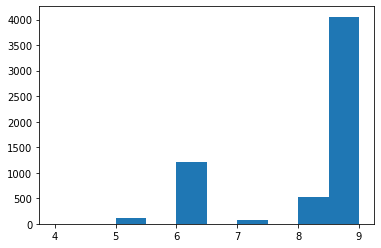

In [38]:
plt.hist([len(i) for i in cti_train])

(array([2.000e+00, 0.000e+00, 8.000e+01, 0.000e+00, 1.116e+03, 0.000e+00,
        7.900e+01, 0.000e+00, 4.980e+02, 4.019e+03]),
 array([4. , 4.5, 5. , 5.5, 6. , 6.5, 7. , 7.5, 8. , 8.5, 9. ]),
 <BarContainer object of 10 artists>)

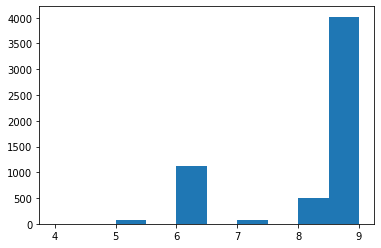

In [39]:
plt.hist([len(i) for i in cti_test])

In [40]:
cti_r_train = [np.random.choice(np.arange(0, 112), size=len(c), replace=False) for c in cti_train]
cti_r_test = [np.random.choice(np.arange(0, 112), size=len(c), replace=False) for c in cti_test]

(array([1.000e+00, 0.000e+00, 1.120e+02, 0.000e+00, 1.203e+03, 0.000e+00,
        8.000e+01, 0.000e+00, 5.320e+02, 4.056e+03]),
 array([4. , 4.5, 5. , 5.5, 6. , 6.5, 7. , 7.5, 8. , 8.5, 9. ]),
 <BarContainer object of 10 artists>)

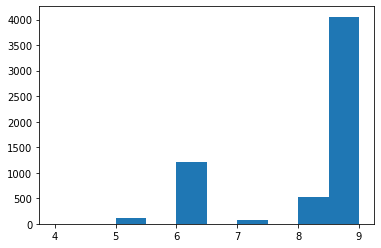

In [41]:
plt.hist([len(i) for i in cti_r_train])

(array([2.000e+00, 0.000e+00, 8.000e+01, 0.000e+00, 1.116e+03, 0.000e+00,
        7.900e+01, 0.000e+00, 4.980e+02, 4.019e+03]),
 array([4. , 4.5, 5. , 5.5, 6. , 6.5, 7. , 7.5, 8. , 8.5, 9. ]),
 <BarContainer object of 10 artists>)

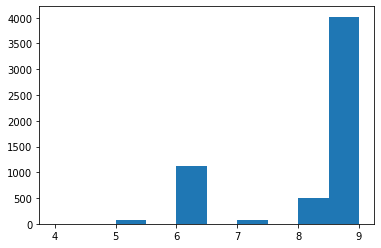

In [42]:
plt.hist([len(i) for i in cti_r_test])

In [47]:
X_train_t

,c1,c2,c3,c4,c5,c6,c7,c8,c9,c10,...,c103,c104,c105,c106,c107,c108,c109,c110,c111,c112
0,-7.435824,-8.171488,4.055655,-6.377162,-3.211594,-4.738883,-8.438566,-3.704345,-6.967831,-7.448850,...,-7.442822,-6.605285,5.909811,-11.524648,-6.473102,-6.578849,-4.890932,-7.630001,-3.317939,-3.734987
1,-7.867685,-9.226110,-5.639320,-6.562392,-3.758889,6.592424,-11.973183,-4.201334,-12.584110,-8.604318,...,-11.076040,-8.896613,-8.307552,-11.182336,-6.278335,-9.455620,-5.929493,-11.540430,-6.228368,-7.360072
2,-5.510104,-8.467843,-3.718968,-5.100006,-4.206491,-3.706867,-10.198762,3.473213,-5.262541,-7.215732,...,-10.067512,-5.809892,-8.339995,-10.015803,4.954406,-7.595245,-4.609553,-9.267011,5.749030,-6.377517
3,-10.370071,-8.393579,3.350000,-4.290375,-6.947193,8.078385,7.428322,-1.919499,-6.813277,-7.175453,...,-8.936077,-9.233739,-2.772201,6.926563,-4.887144,-9.203645,-5.234711,-8.225325,-6.554788,5.762831
4,-11.393475,-10.355107,1.396802,5.831507,5.696030,-6.013880,-7.973518,-4.745125,-9.713301,9.295158,...,-8.817182,-6.933283,-9.769760,-12.866199,-4.500919,-8.986675,-5.365304,-9.638665,-4.782470,-4.539772
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5979,-5.454701,-9.059090,-2.757111,-3.866209,-3.923048,-5.545717,-6.793813,-1.597942,-5.341044,-8.263652,...,-7.293048,-5.984199,-7.468648,-7.657919,-2.822167,-8.374503,-5.954087,-7.562548,-4.880558,3.823661
5980,-8.232608,-10.145750,4.288532,-6.583756,-4.077713,-6.308272,-8.499595,4.462934,5.669048,-6.751323,...,-8.418234,-7.933400,-5.929561,-10.099409,4.975705,-9.590421,-5.390080,-7.488389,-5.779944,3.915880
5981,6.307443,-6.304258,-2.841606,-6.215339,-4.032948,-5.331889,-8.799405,3.011732,-4.989781,-7.247531,...,-7.217008,-5.900223,-5.894669,-8.765395,-2.370361,-8.186172,4.781214,-6.106098,-4.406340,-5.435298
5982,7.601789,-7.696479,-4.301916,-7.196651,-4.704927,-6.682792,-10.100412,3.865421,-6.413815,-8.802442,...,-8.931219,-7.175624,-7.796584,-10.830974,-1.944193,-9.642138,6.098357,-7.952409,-5.452198,-6.065164


In [52]:
X_train_d_r_edit = X_train_d.copy()
X_train_t_r_edit = X_train_t.copy()

for i in range(len(cti_r_train)):
    X_train_d_r_edit.iloc[i, cti_r_train[i]] = X_train.iloc[i, cti_r_train[i]] #train_q5d[cti_r_train[i]]*(X_train.iloc[i, cti_r_train[i]] == 0) + train_q95d[cti_r_train[i]]*(X_train.iloc[i, cti_r_train[i]])
    X_train_t_r_edit.iloc[i, cti_r_train[i]] = X_train.iloc[i, cti_r_train[i]] #train_q5[cti_r_train[i]]*(X_train.iloc[i, cti_r_train[i]] == 0) + train_q95[cti_r_train[i]]*(X_train.iloc[i, cti_r_train[i]])

X_test_d_r_edit = X_test_d.copy()
X_test_t_r_edit = X_test_t.copy()

for i in range(len(cti_r_test)):
    X_test_d_r_edit.iloc[i, cti_r_test[i]] = X_test.iloc[i, cti_r_test[i]] #train_q5d[cti_r_test[i]]*(X_test.iloc[i, cti_r_test[i]] == 0) + train_q95d[cti_r_test[i]]*(X_test.iloc[i, cti_r_test[i]])
    X_test_t_r_edit.iloc[i, cti_r_test[i]] = X_test.iloc[i, cti_r_test[i]] #train_q5[cti_r_test[i]]*(X_test.iloc[i, cti_r_test[i]] == 0) + train_q95[cti_r_test[i]]*(X_test.iloc[i, cti_r_test[i]])

y_train_t_eval_r_interv = process_teacher_eval(predict_teacher(teacher, X_train_t_r_edit))
y_test_t_eval_r_interv = process_teacher_eval(predict_teacher(teacher, X_test_t_r_edit))

r = evaluate_student(figs_student, X_train_d_r_edit, X_test_d_r_edit, y_train_t_eval_r_interv, y_test_t_eval_r_interv, args.metric, "distillation_rand_interv", r)
r = evaluate_student(figs_student, X_train_d_r_edit, X_test_d_r_edit, y_train, y_test, args.metric, "prediction_rand_interv", r)

r = evaluate_teacher(y_train_t_eval_r_interv, y_test_t_eval_r_interv, y_train, y_test, args.metric, "prediction_rand_interv", r)

,c1,c2,c3,c4,c5,c6,c7,c8,c9,c10,...,c103,c104,c105,c106,c107,c108,c109,c110,c111,c112
0,0,0,1,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
1,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,1,0,0,0,1,0
3,0,0,1,0,0,1,1,0,0,0,...,0,0,0,1,0,0,0,0,0,1
4,0,0,1,1,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5979,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
5980,0,0,1,0,0,0,0,1,1,0,...,0,0,0,0,1,0,0,0,0,1
5981,1,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,1,0,0,0
5982,1,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,1,0,0,0


In [53]:
args.num_interactions_intervention * args.max_depth

12

In [56]:
#thresh = 0.45
r

defaultdict(list,
            {'student_distillation_train_accuracy': 0.9204545454545454,
             'student_distillation_test_accuracy': 0.8263721090783569,
             'student_prediction_train_accuracy': 0.9154411764705882,
             'student_prediction_test_accuracy': 0.7183293061788056,
             'teacher_prediction_train_accuracy': 0.9528743315508021,
             'teacher_prediction_test_accuracy': 0.7744218156713842,
             'student_distillation_adap_interv_train_accuracy': 0.14154411764705882,
             'student_distillation_adap_interv_test_accuracy': 0.12426648256817398,
             'student_prediction_adap_interv_train_accuracy': 0.8783422459893048,
             'student_prediction_adap_interv_test_accuracy': 0.7373144632378322,
             'teacher_prediction_adap_interv_train_accuracy': 0.16243315508021391,
             'teacher_prediction_adap_interv_test_accuracy': 0.1318605453917846,
             'student_distillation_rand_interv_train_accuracy': 0

In [21]:
#thresh = median of training values
r

defaultdict(list,
            {'student_distillation_train_accuracy': 0.8078208556149733,
             'student_distillation_test_accuracy': 0.7045219192267863,
             'student_prediction_train_accuracy': 0.8001336898395722,
             'student_prediction_test_accuracy': 0.6567138419054194,
             'teacher_prediction_train_accuracy': 0.9380013368983957,
             'teacher_prediction_test_accuracy': 0.8310321021746634,
             'student_distillation_adap_interv_train_accuracy': 0.7357954545454546,
             'student_distillation_adap_interv_test_accuracy': 0.6561960648947187,
             'student_prediction_adap_interv_train_accuracy': 0.736129679144385,
             'student_prediction_adap_interv_test_accuracy': 0.6183983431135658,
             'teacher_prediction_adap_interv_train_accuracy': 0.9177807486631016,
             'teacher_prediction_adap_interv_test_accuracy': 0.8167069382119434,
             'student_distillation_rand_interv_train_accuracy': 0.770

In [22]:
#thresh = 0
r

defaultdict(list,
            {'student_distillation_train_accuracy': 0.8078208556149733,
             'student_distillation_test_accuracy': 0.7045219192267863,
             'student_prediction_train_accuracy': 0.8001336898395722,
             'student_prediction_test_accuracy': 0.6567138419054194,
             'teacher_prediction_train_accuracy': 0.9380013368983957,
             'teacher_prediction_test_accuracy': 0.8310321021746634,
             'student_distillation_adap_interv_train_accuracy': 0.7357954545454546,
             'student_distillation_adap_interv_test_accuracy': 0.6561960648947187,
             'student_prediction_adap_interv_train_accuracy': 0.736129679144385,
             'student_prediction_adap_interv_test_accuracy': 0.6183983431135658,
             'teacher_prediction_adap_interv_train_accuracy': 0.9177807486631016,
             'teacher_prediction_adap_interv_test_accuracy': 0.8167069382119434,
             'student_distillation_rand_interv_train_accuracy': 0.770

In [23]:
len(figs_student.trees_)

25